# Chapter 3: Classification
Notes for *Hands on Machine Learning with Scikit by Aurelien Geron*. This is on Chapter 3: Classification, where it explains the fundamentals on how Machine Learning identify one group from the other using statistics.

# Getting Started
The dataset used is the *MNIST*, which is a collection of handwritten numbers in the format of image pixels. The goal is to have the machine tell us what number is in each image.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

You can download a copy of the dataset from sklearn. This gets updated often, which is why it is different on the book.

In [2]:
df, target = mnist["data"], mnist["target"]

We separate the data from the labels. I usually use *df* for the main data and *target* as the labels. *df*, which is short for dataframe, are the questions we ask the machine and *target* are the answer keys, which tells us which number it is.

In [3]:
print('dataframe', df.shape)
print('target', target.shape)

dataframe (70000, 784)
target (70000,)


In [14]:
df.iloc[0].describe()

count    784.000000
mean      35.108418
std       79.699674
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      255.000000
Name: 0, dtype: float64

There are 70,000 numbers in the dataset and each number holds 784 pixels. Each pixel has a value between 0 to 255, which indicates the intensity of the black color. Remember that each datapoint is an image of a number.

## Split Train Test
We split the data between *Train* and *Test*. We use the *Train* for majority of our exploration and data engineering. The *Test* is only used at the very end, where we validate our results.

In [15]:
train_df, test_df, train_target, test_target = df[:60000], df[60000:], target[:60000], target[60000:]

The MINST dataset is already dividied into Train and Test. The first 60k rows is the Train and the rest are the Test.

In [16]:
import numpy as np
shuffle_index = np.random.permutation(60000)
train_df, train_target = train_df.iloc[shuffle_index], train_target.iloc[shuffle_index]

There is a chance that the numbers are in order in a way that it will affect our models (Like a new deck of cards, we would always shuffle it before using them). Here, we shuffle it using the index.

# Explore Data
Our data is prepapred. It is time to Explore, Clean and Machine Learning the shit out of it. This section is where we keep all our Exploring data.

3


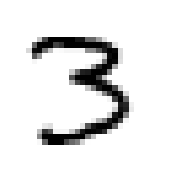

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = train_df.iloc[0].values
roll = train_target.iloc[0] # Keep your first digit in roll cause it will keep changing.
print(roll)
plt.figure(figsize=(2,2))
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

We render the first number on our dataset to see what it looks like. The grid is 28 by 28 pixels where each value ranges between 0 to 255, which inidicates the intensity of the black color. The first number of your dataset will keep changing, so better keep in the variable roll.

# Clean Data
In this section, we Clean the data.

In [22]:
import numpy as np
train_target = train_target.astype(np.uint8)
test_target = test_target.astype(np.uint8)

The values of each targets are strings. We want them as intigers.

# Machine Learning
In this section, we do our Machine Learning algorithms. We start with an easy algorithm, then we work our way up to the more complex ones.

## Stochastic Gradient Descent
We start by identifying our *roll* number. We use SGD for this task, which apparently deals with training instances independently.

In [34]:
train_target_roll = (train_target == int(roll))
# test_roll = (test_target==roll)

Instead of finding out what number it is, we just check if that number is our *roll* number - TRUE or FALSE.

In [37]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(train_df, train_target_roll)
sgd_clf.predict([some_digit])

array([ True])

The model correctly predicts that *some_digit* is the same with *roll*. Let's see how accurate this model is in predicting the whole training set.

In [38]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_df, train_target_roll, cv=3, scoring="accuracy")

array([0.94495, 0.9561 , 0.95595])

*cross_val_score* splits the training data into 3 folds and uses 2 folds as training data and 1 fold as the test. It does this 3 times in different combination. The result shows that on average, the model is accurate around ~95% of the time. Accuracy is unusually high. We try it out on dumber model and see what the results are.

In [40]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [41]:
never_roll_clf = Never5Classifier()
cross_val_score(never_roll_clf, train_df, train_target_roll, cv=3, scoring="accuracy")

array([0.8949 , 0.8984 , 0.90015])

Again, we get very high results. This is because ~90% of the numbers are not the same with the *roll* number. So, if the model says that all numbers are not the same with *roll* (All FALSE), then the accuracy would be around ~90%. This is why accuracy, as a measure of classification, sucks.

## Confusion Matrix
Instead just counting the correct predictions, Confusion Matrix also takes into account the wrong predictions. This creates balance in the way 

In [51]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, train_df, train_roll, cv=3)

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_roll, y_train_pred)

array([[53357,   725],
       [  539,  5379]], dtype=int64)

In [53]:
y_train_pred_perfect = train_roll
confusion_matrix(train_roll, y_train_pred_perfect)

array([[54082,     0],
       [    0,  5918]], dtype=int64)

In [59]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(train_roll, y_train_pred)
precision

0.8812254259501966

In [60]:
recall = recall_score(train_roll, y_train_pred)
recall

0.9089219330855018

### F1 score
Harmonic mean gives more weigh to low values. Regular mean will weight the 2 values equal.

In [65]:
from sklearn.metrics import f1_score
print('mean: ', (precision + recall) / 2)
print('f1: ', f1_score(train_roll, y_train_pred))

mean:  0.4411127129750983
f1:  0.8948594243886209


### Threshold

In [57]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([5121.19071847])

In [58]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])